In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime, date, time
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
# ielādē dotos datus
path = "C:/Users/ilzep/Documents/SadalesTikls/"
grob = "GrobinasVES.xlsx"
energ = pd.read_excel(path+grob)

energ['datums'] = pd.to_datetime(energ['datums'], format='%d.%m.%Y')
energ['laiks'] = pd.to_datetime(energ['laiks'], format='%H:%M:%S')
energ['laiks'] = energ['laiks'].dt.time
energ['datums'] = energ['datums'].dt.date

energ['DateTime'] = energ.apply(lambda row: datetime.combine(row['datums'], row['laiks']), axis=1)
energ.drop(['datums', 'laiks'], axis=1, inplace=True)

In [3]:
# ielādē un apvieno meteoroloģisko datu failus
files = [
    "veja_atrums.xlsx", #fakt
    "veja_atr_minim.xlsx",
    "brazmas_stunda.xlsx",
    "veja_virziens.xlsx", # fakt
    "temperatura.xlsx", #fakt
    "mitrums.xlsx", #fakt
    "spiediens.xlsx"  # fakt
]
meteo = None

for file in files:
    df = pd.read_excel(path+file)
    df = df.drop([0]).reset_index(drop=True)
    df.columns = df.iloc[0]
    df = df.drop(0).reset_index(drop=True)
    
    df_melted = df.melt(id_vars=['Datums'], var_name='laiks', value_name='Value')
    df_melted['Value'] = pd.to_numeric(df_melted['Value'])
    column_name = file.split('.')[0]  
    df_melted = df_melted[['Datums', 'laiks', 'Value']].rename(columns={'Value': column_name})
    df_melted['Datums'] = pd.to_datetime(df_melted['Datums'], format='%d.%m.%Y')
    df_melted['laiks'] = pd.to_datetime(df_melted['laiks'], format='%H:%M')
    df_melted['laiks'] = df_melted['laiks'].dt.time    
    df_melted['DateTime'] = df_melted.apply(lambda row: datetime.combine(row['Datums'], row['laiks']), axis=1)    
    df_melted.drop(['Datums', 'laiks'], axis=1, inplace=True)
    if meteo is None:
        meteo = df_melted
    else:
        meteo = pd.merge(meteo, df_melted, on=['DateTime'], how='outer')

In [4]:
# gaisa blīvuma aprēķins
e0 = 610.5
T1 = 17.269
T2 = 237.3
R = 287

meteo['E'] = e0 * np.exp((T1 * meteo['temperatura']) / (T2 + meteo['temperatura']))
meteo['e'] = meteo['E'] * meteo['mitrums'] / 100
meteo['blivums'] = (meteo['spiediens']*100 / (R * (meteo['temperatura']+273))) * (1 - (0.378 * meteo['e'] / (meteo['spiediens']*100)))
meteo = meteo.drop(columns=['E', 'e'])

In [5]:
meteo['atrums^3'] = meteo['veja_atrums']**3
meteo['brazmas_stunda^3'] = meteo['brazmas_stunda']**3
meteo['vejs_vid'] = (meteo['veja_atr_minim'] + meteo['brazmas_stunda'])/2
meteo['vejs_vid^3'] = meteo['vejs_vid']**3
meteo['brazmainums'] = meteo['brazmas_stunda'] - meteo['veja_atr_minim']

In [6]:
# sadalu meteo datus tajos, kam ir zināms ģenerētās enerģijas daudzums, un tajos, kam jāprognozē
split_date = pd.to_datetime('01.06.2023', format='%d.%m.%Y')
meteo_maijs = meteo[meteo['DateTime'] < split_date]
meteo_jun_jul = meteo[meteo['DateTime'] >= split_date]

In [7]:
dati = pd.merge(energ, meteo_maijs, on=['DateTime'], how='inner')
dati_cleaned = dati.dropna()

In [8]:
# aprēķinu korelāciju starp visiem lielumiem
kolonnas = ['kWh', 'veja_atrums', 'atrums^3', 'vejs_vid', 'vejs_vid^3', 'brazmas_stunda', 'brazmas_stunda^3', 'brazmainums', 'veja_atr_minim',
           'blivums', 'mitrums', 'temperatura']
mat = dati[kolonnas]
correlation_matrix = mat.corr()
correlation_matrix

,kWh,veja_atrums,atrums^3,vejs_vid,vejs_vid^3,brazmas_stunda,brazmas_stunda^3,brazmainums,veja_atr_minim,blivums,mitrums,temperatura
kWh,1.000000,0.659993,0.744639,0.651503,0.726409,0.643419,0.730472,0.629879,0.442764,0.072187,0.003715,-0.160282
veja_atrums,0.659993,1.000000,0.894150,0.925511,0.841920,0.919003,0.837518,0.905231,0.577437,-0.199605,-0.295422,0.157436
atrums^3,0.744639,0.894150,1.000000,0.821065,0.904733,0.811247,0.892318,0.794590,0.554160,-0.129487,-0.109106,0.053207
vejs_vid,0.651503,0.925511,0.821065,1.000000,0.901390,0.996917,0.902009,0.986369,0.583023,-0.199980,-0.302335,0.162812
vejs_vid^3,0.726409,0.841920,0.904733,0.901390,1.000000,0.894401,0.992004,0.880274,0.569123,-0.137890,-0.137246,0.066556
brazmas_stunda,0.643419,0.919003,0.811247,0.996917,0.894401,1.000000,0.902434,0.996239,0.517482,-0.221352,-0.307955,0.185395
brazmas_stunda^3,0.730472,0.837518,0.892318,0.902009,0.992004,0.902434,1.000000,0.896436,0.492699,-0.153117,-0.141038,0.086488
brazmainums,0.629879,0.905231,0.794590,0.986369,0.880274,0.996239,0.896436,1.000000,0.441388,-0.243370,-0.311956,0.209009
veja_atr_minim,0.442764,0.577437,0.554160,0.583023,0.569123,0.517482,0.492699,0.441388,1.000000,0.111100,-0.108419,-0.144132
blivums,0.072187,-0.199605,-0.129487,-0.199980,-0.137890,-0.221352,-0.153117,-0.243370,0.111100,1.000000,0.501110,-0.964320


In [9]:
# Linear Regression
kol_LR = ['atrums^3', 'blivums', 'brazmainums', 'temperatura']
X = dati_cleaned[kol_LR]
y = dati_cleaned['kWh']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_LR = LinearRegression()
model_LR.fit(X_train, y_train)

y_LR = model_LR.predict(X_test)
rmse_LR = np.sqrt(mean_squared_error(y_test, y_LR))
r2_LR = r2_score(y_test, y_LR)

In [10]:
kolonnas = ['veja_atrums', 'atrums^3', 'vejs_vid', 'vejs_vid^3', 'brazmas_stunda', 'brazmas_stunda^3', 'brazmainums', 'veja_atr_minim',
           'blivums', 'mitrums', 'temperatura']
X = dati_cleaned[kolonnas]
y = dati_cleaned['kWh']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Gradient Boosting
gbr = GradientBoostingRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 5, 10, 12],
    'min_samples_leaf': [1, 2, 4, 5],
    'subsample': [0.7, 0.8, 1.0]
}
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0) 
grid_search.fit(X_train, y_train)

best_gbr = grid_search.best_estimator_
y_GBR = best_gbr.predict(X_test)
rmse_GBR = np.sqrt(mean_squared_error(y_test, y_GBR))
r2_GBR = r2_score(y_test, y_GBR)

In [12]:
# Random Forest
rf = RandomForestRegressor(max_features='sqrt', random_state=42)
param_grid = {
    'n_estimators': [80, 100, 200, 300],
    'max_depth': [5, 7, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]    
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0) #neg_mean_squared_error

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_RF = best_rf.predict(X_test)
rmse_RF = np.sqrt(mean_squared_error(y_test, y_RF))
r2_RF = r2_score(y_test, y_RF)

In [13]:
# visu 3 metožu apvienojums
sal = pd.DataFrame(y_test)
sal['LR'] = y_LR
sal['GBR'] = y_GBR
sal['RF'] = y_RF
sal['total'] = (sal['LR']+sal['GBR']+sal['RF'])/3
rmse_tot = np.sqrt(mean_squared_error(y_test, sal['total']))
r2_tot = r2_score(y_test, sal['total'])

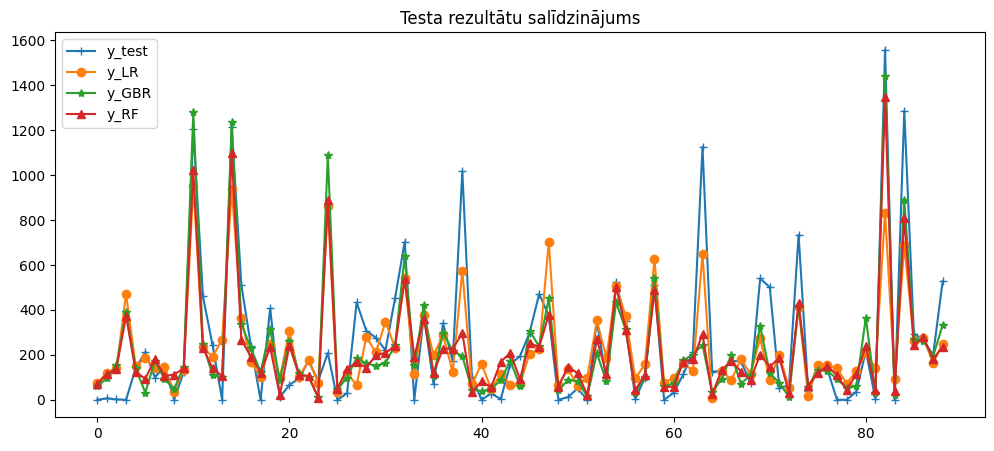

In [14]:
# 3 metožu testa rezultātu salīdzinājums
x = np.arange(89)
plt.figure(figsize=(12, 5))
plt.plot(x, y_test, label='y_test', marker='+')
plt.plot(x, y_LR, label='y_LR', marker='o')
plt.plot(x, y_GBR, label='y_GBR', marker='*')
plt.plot(x, y_RF, label='y_RF', marker='^')

plt.legend()
plt.title('Testa rezultātu salīdzinājums')
plt.show()

In [15]:
# 3 metožu skaitlisks novērtējums
modeli = {
    'Model': ['Linear Regression', 'Gradient Boosting', 'Random Forest', 'Total'],
    'RMSE': [rmse_LR, rmse_GBR, rmse_RF, rmse_tot],  
    'R²': [r2_LR, r2_GBR, r2_RF, r2_tot] 
}
vertejums = pd.DataFrame(modeli)
vertejums

,Model,RMSE,R²
0,Linear Regression,199.111650,0.614909
1,Gradient Boosting,199.618315,0.612946
2,Random Forest,193.004482,0.638170
3,Total,188.646323,0.654326


In [16]:
# dati prognozēšanai
meteo_jun_jul = meteo_jun_jul.dropna()
new_data = meteo_jun_jul[kolonnas]
dati_LR = meteo_jun_jul[kol_LR]

In [17]:
# prognozēšana
predictions_GBR = best_gbr.predict(new_data)
predictions_RF = best_rf.predict(new_data)
predictions_LR = model_LR.predict(dati_LR)

In [18]:
results = meteo_jun_jul[['DateTime']].copy()
results['LR'] = predictions_LR
results['GBR'] = predictions_GBR
results['RF'] = predictions_RF

results['kWh'] = (results['LR']+results['GBR']+results['RF'])/3
results = results.drop(columns=['LR', 'GBR', 'RF'])

In [19]:
results.to_excel(path+'VES_prognoze.xlsx', index=False)